In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams['axes.unicode_minus'] = False #그래프에서 마이너스 폰트 깨지는것 처리

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("dataset/train.csv", parse_dates = ["datetime"])
train.shape

(10886, 12)

In [3]:
test = pd.read_csv("dataset/test.csv", parse_dates = ["datetime"])
test.shape

(6493, 9)

### Feature Engineering

In [4]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [5]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

<AxesSubplot:title={'center':'test windspeed'}, xlabel='windspeed', ylabel='count'>

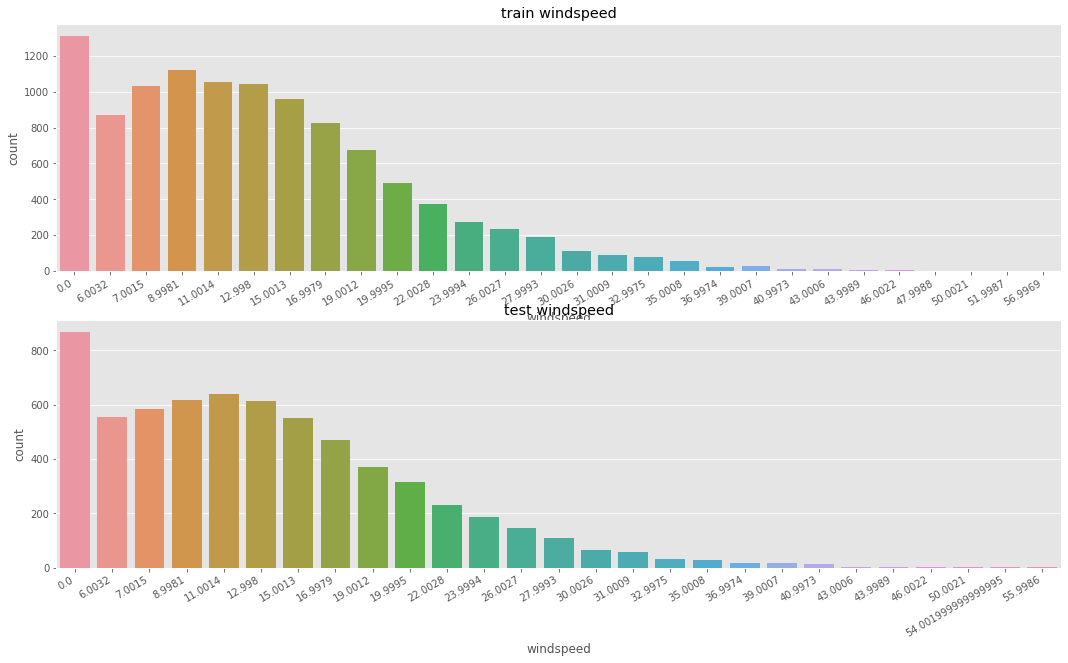

In [6]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="test windspeed")
sns.countplot(data=test, x="windspeed", ax=axes[1])

풍속이 0인 값이 많은 것을 보니 무의미한 것 같다. 이에 의미를 부여하기 위해
- 일괄적으로 평균값 등으로 처리하거나
<pre><code>train.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()
test.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()</code></pre>
- 풍속을 예측하여 대체값으로 사용할 수 있겠다.

In [7]:
train_wind_0 = train.loc[train["windspeed"] == 0]
train_wind_not0 = train.loc[train["windspeed"] != 0]
print(train_wind_0.shape)
print(train_wind_not0.shape)

(1313, 19)
(9573, 19)


In [8]:
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    data_wind_0 = data.loc[data["windspeed"] == 0]
    data_wind_not0 = data.loc[data["windspeed"] != 0]
    
    windCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]
    data_wind_not0["windspeed"] = data_wind_not0["windspeed"].astype('str')
    
    rf = RandomForestClassifier()
    rf.fit(data_wind_not0[windCol], data_wind_not0["windspeed"])
    values = rf.predict(data_wind_0[windCol])
    
    predict_wind_0 = data_wind_0
    predict_wind_not0 = data_wind_not0
    
    predict_wind_0["windspeed"] = values
    
    data = predict_wind_not0.append(predict_wind_0)
    data["windspeed"] = data["windspeed"].astype('float')
    
    data.reset_index(inplace = True)
    data.drop('index', inplace = True, axis = 1)
    
    return data

<AxesSubplot:title={'center':'train windspeed'}, xlabel='windspeed', ylabel='count'>

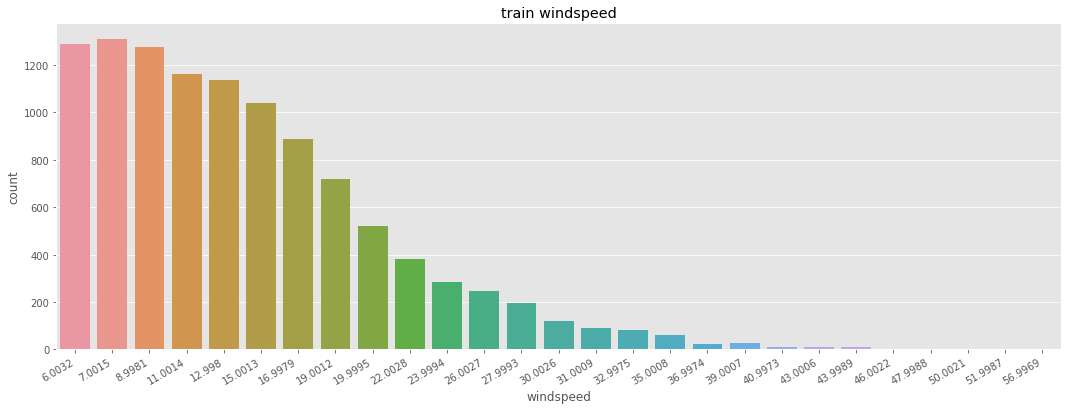

In [9]:
train = predict_windspeed(train)

fig,ax1 = plt.subplots()
fig.set_size_inches(18, 6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel = 'Count', title = "train windspeed")
sns.countplot(data = train, x = "windspeed", ax = ax1)

#### feature selection

In [10]:
# 연속형 feature = ["temp","humidity","windspeed","atemp"]
categorical_feature_names = ["season", "holiday", "workingday", "weather", "dayofweek", "month", "year", "hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [11]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed", "year", "hour", "dayofweek", "holiday", "workingday"]
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [12]:
X_train = train[feature_names]
X_train.head()

,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [13]:
X_test = test[feature_names]
X_test.head()

,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [14]:
label_name = "count"
y_train = train[label_name]
y_train.head()

0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

#### Evaluation

In [15]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # difference = (log_predict - log_actual) ** 2
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [16]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits = 10, shuffle = True, random_state = 0)

In [17]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []
model = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 0)
model

RandomForestRegressor(n_jobs=-1, random_state=0)

In [18]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
print("Score= {0:.5f}".format(score))

CPU times: user 3.87 s, sys: 2.29 s, total: 6.16 s
Wall time: 8.22 s
Score= 0.33125


### Train

In [19]:
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [20]:
predictions = model.predict(X_test)
print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.73,   4.95,   4.27,   3.62,   3.06,   6.44,  38.48, 105.31,
       235.98, 135.65])

[Text(0.5, 1.0, 'test')]

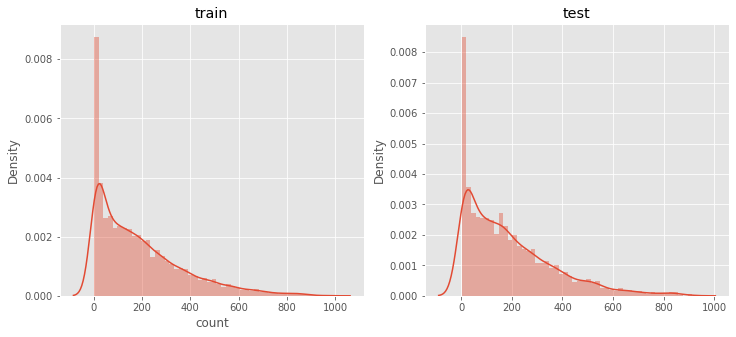

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title = "train")
sns.distplot(predictions, ax=ax2, bins=50)
ax2.set(title = "test")

In [23]:
submission = pd.read_csv("dataset/sampleSubmission.csv")
submission["count"] = predictions
submission.head()

,datetime,count
0,2011-01-20 00:00:00,12.73
1,2011-01-20 01:00:00,4.95
2,2011-01-20 02:00:00,4.27
3,2011-01-20 03:00:00,3.62
4,2011-01-20 04:00:00,3.06


In [24]:
submission.to_csv("dataset/Score_{0:.5f}_submission.csv".format(score), index=False)